# Feature Detecting and Matching Pipeline

In [1]:
import cv2
import numpy as np
import random
from matplotlib import pyplot as plt

def displayImage(img):
    plt.imshow(img)
    plt.show()


## FAST DETECTION

In [2]:
ROW_INDICES=[-3, -3, -2, -1, 0, 1, 2, 3, 3,  3,  2,  1,  0, -1, -2, -3]
COL_INDICES=[ 0,  1,  2,  3, 3, 3, 2, 1, 0, -1, -2, -3, -3, -3, -2, -1]
FAST_FIRST_TEST_PIX = [0, 4, 8, 12]
FAST_RADIUS=3

# Get the values of the positions on a circle around a point in a grayscale image
# Param img: a grayscale image
# Params row,col: position of a pixel (similar to y and x)
# Return: array of pixel values
def get_circle3x3(img, row, col):
    pixels = np.empty(16)
    for i in range(0,16,1):
        pixels[i]=img[row+ROW_INDICES[i],col+COL_INDICES[i]]
    return pixels

# Get the x and y coordinates of feature points detected with FAST Detection
# Param img: a grayscale image
# Param threshold: a gray value between 1 and 254
# Param borderWidth: the width of borders in images, where no feature point should be detected
# Returns: arrays of x ( in result[0]) and y ( in result[1]) values
def FASTDetection(img, threshold, borderWidth=0):
    xs=[]
    ys=[]
    # iterate through columns of image
    for col in range(FAST_RADIUS+borderWidth, np.size(img, 1)-(FAST_RADIUS+1)-borderWidth):
        # iterate through rows of image
        for row in range(FAST_RADIUS+borderWidth, np.size(img, 0)-(FAST_RADIUS+1)-borderWidth):
            # define brightness limits for corner validation
            lbound = img[row, col] - threshold
            ubound = img[row, col] + threshold

            # get pixels important for corner validation
            pixels = get_circle3x3(img, row, col)

            # count how many of the fast test pixels are different
            diff_count = 0
            for x in FAST_FIRST_TEST_PIX:
                #check if pixel are strongly different from centered pixel 
                if pixels[x] < lbound or pixels[x] > ubound:
                    diff_count = diff_count + 1

            # if more than 2 fast test pixels are different test the complete surrounding of Xi
            if diff_count > 2:
                diff_count=0
                for pixel in pixels:
                    if pixel < lbound or pixel > ubound:
                        diff_count = diff_count + 1
                if diff_count > 12:
                    xs.append(col)
                    ys.append(row)
    return [xs, ys]

## BRIEF DESCRIPTOR

In [3]:
ERROR_HAMMING_CODE=-1


# Generate random pairs of x and y values for BRIEF descriptor
# Param numberOfElems: the number of points pairs
# Param span: represent how far the points should be generated
# Returns randomized x coordinates ( in result[0] and result[2]) and y coordinates ( in result[1] and result[3])
def generateBRIEFRandomPosition(numberOfElems,span):
    xs1=[]
    ys1=[]
    xs2=[]
    ys2=[]
    for i in range(0,numberOfElems,1):
        xs1.append(random.randint(-span,span))
        ys1.append(random.randint(-span,span))
        xs2.append(random.randint(-span,span))
        ys2.append(random.randint(-span,span))
    return [xs1,ys1,xs2,ys2]


# Describe the found feature points in a grayscale image
# Param img: a grayscale image
# Param featuresPosition:    array of x ( in f[0] ) and y ( in f[1] ) coordinates of feature points
# Param briefRandomPosition: array of x ( in f[0] ) and y ( in f[1] ) coordinates of randomized points
# Returns BRIEF descriptor for each point as an array of 0s and 1s (or ERROR_HAMMING_CODE=-1 if the feature cannot be described)
def BRIEFDescription(img, featuresPosition, briefRandomPosition):
    height=np.size(img,0)
    width=np.size(img,1)
    binCode=[]
    for i in range(0,len(featuresPosition[0]),1):
        d=np.empty(len(briefRandomPosition[0]))
        for j in range(0,len(briefRandomPosition[0])):
            p1y=featuresPosition[1][i]+briefRandomPosition[1][j]
            p1x=featuresPosition[0][i]+briefRandomPosition[0][j]
            p2y=featuresPosition[1][i]+briefRandomPosition[3][j]
            p2x=featuresPosition[0][i]+briefRandomPosition[2][j]
            if p1y>0 and p1x>0 and p2y>0 and p2x>0 and p1y<height and p1x<width and p2y<height and p2x<width:
                pix1=img[p1y,p1x]
                pix2=img[p2y,p2x]
                d[j]=0 if pix1<pix2 else 1
            else:
                d[j]=ERROR_HAMMING_CODE
                break
        binCode.append(d)
    return binCode


# Calculate Hamming Distance between two BRIEF described feature points
# Param code1, code2: BRIEF descriptors of two points
# Returns: the total number of differences between two points or ERROR_HAMMING_CODE=-1 if not possible.
def hammingDistance(code1,code2):
    d=0
    for i in range(0,len(code1),1):
        if code1[i]==ERROR_HAMMING_CODE or code2[i]==ERROR_HAMMING_CODE:
            d=ERROR_HAMMING_CODE
            break
        elif code1[i]!=code2[i]:
            d=d+1
    return d


# Match BRIEF described feature points between two images using Hamming Distance (unless it's ERROR_HAMMING_CODE=-1)
# Params binCode1, binCode2: arrays of BRIEF descriptors
# Returns indices of match pairs from image 1 ( in result[0]) and image 2 ( in result[1])
def BRIEFMatcher(binCode1, binCode2,threshold):
    match1=[]
    match2=[]
    for i1 in range(0,len(binCode1),1):
        for i2 in range(0,len(binCode2),1):
            h=hammingDistance(binCode1[i1],binCode2[i2])
            if h<threshold and h!=ERROR_HAMMING_CODE:
                match1.append(i1)
                match2.append(i2)
    return [match1, match2]

## PIPELINE

In [4]:
R_SIZE=3          # A constant to draw rectangles in images
THRESHOLD_FAST=64 # Gray value between 1 and 254 for FAST Detection
THRESHOLD_BRIEF=8 # Threshold value for BRIEF matching, should be smaller than N_BRIEF_ARRAY
N_BRIEF_ARRAY=64  # Number of randomized element for BRIEF matching
N_BRIEF_SPAN=32   # The maximum elemental distance of the randomized coordinates to 0


# Read in 2 images, detect feature points of them, describe feature points and match them
# Params img1, img2: input images
# Param output: generate visualized images with features and matching
# Returns feature positions ( in result[0] and result[1]) and matched indices ( in result[2] and result[3])

def detectAndMatchFeatures(img1, img2, output=True):
    if output==True:
        print("Image 1:")
        displayImage(img1)
        print("Image 2:")
        displayImage(img2)
    # Copy and convert to grayscale images
    copyImg1=img1.copy()
    img1Gray = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
    copyImg2=img2.copy()
    img2Gray = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)
    print("Images loaded")
    # FAST Detection
    pos1=FASTDetection(img1Gray,THRESHOLD_FAST,N_BRIEF_SPAN)
    print("Features extracted from image 1")
    if output==True:
        for i in range(0,len(pos1[0]),1):
            p1=(pos1[0][i]-R_SIZE,pos1[1][i]-R_SIZE)
            p2=(pos1[0][i]+R_SIZE,pos1[1][i]+R_SIZE)
            print("Feature Nr.", i, ":(x1=",pos1[0][i],";y1=",pos1[1][i],").")
            c=(255 if i%3==0 else 0,255 if i%3==1 else 0,255 if i%3==2 else 0)
            cv2.rectangle(copyImg1,p1,p2,c,-1)
        displayImage(copyImg1)
        #cv2.imwrite(img1Name+"_features.jpg",copyImg1)
    pos2=FASTDetection(img2Gray,THRESHOLD_FAST,N_BRIEF_SPAN)
    print("Features extracted from image 2")
    if output==True:
        for i in range(0,len(pos2[0]),1):
            p1=(pos2[0][i]-R_SIZE,pos2[1][i]-R_SIZE)
            p2=(pos2[0][i]+R_SIZE,pos2[1][i]+R_SIZE)
            print("Feature Nr.", i, ":(x2=",pos2[0][i],";y2=",pos2[1][i],").")
            c=(255 if i%3==0 else 0,255 if i%3==1 else 0,255 if i%3==2 else 0)
            cv2.rectangle(copyImg2,p1,p2,c,-1)
        displayImage(copyImg2)
        #cv2.imwrite(img2Name+"_features.jpg",copyImg2)
    # BRIEF Description
    briefParameter=generateBRIEFRandomPosition(N_BRIEF_ARRAY,N_BRIEF_SPAN)
    des1=BRIEFDescription(img1Gray,pos1,briefParameter)
    des2=BRIEFDescription(img2Gray,pos2,briefParameter)
    print("Features described")
    # BRIEF Matching
    matches=BRIEFMatcher(des1,des2,THRESHOLD_BRIEF)
    print("Features matched")
    if output==True:
        # Fill image with shorter height and combine the images
        fill1=0
        fill2=0
        if np.size(img1,0)==np.size(img2,0):
            combined=cv2.hconcat([img1,img2])
        else:
            maxHeight=np.max([np.size(img1,0),np.size(img2,0)])
            minHeight=np.min([np.size(img1,0),np.size(img2,0)])
            fill1=maxHeight-np.size(img1,0)
            fill2=maxHeight-np.size(img2,0)
            img1f=[]
            img2f=[]
            if fill1!=0:
                f=np.zeros((maxHeight-minHeight,np.size(img1,1),3),np.uint8)
                img1f=cv2.vconcat([f,img1])
                img2f=img2.copy()
            else:
                f=np.zeros((maxHeight-minHeight,np.size(img2,1),3),np.uint8)
                img2f=cv2.vconcat([f,img2])
                img1f=img1.copy()
            combined=cv2.hconcat([img1f,img2f])
        # Draw matches
        for i in range(0,len(matches[0]),1):
            p1a=(pos1[0][matches[0][i]]-R_SIZE,fill1+pos1[1][matches[0][i]]-R_SIZE)
            p1b=(pos1[0][matches[0][i]]+R_SIZE,fill1+pos1[1][matches[0][i]]+R_SIZE)
            p2a=(pos2[0][matches[1][i]]-R_SIZE+np.size(img1, 1),fill2+pos2[1][matches[1][i]]-R_SIZE)
            p2b=(pos2[0][matches[1][i]]+R_SIZE+np.size(img1, 1),fill2+pos2[1][matches[1][i]]+R_SIZE)
            c=(255 if i%3==0 else 0,255 if i%3==1 else 0,255 if i%3==2 else 0)
            print("Match Nr.", i, ":(x1=",pos1[0][matches[0][i]],";y1=",pos1[1][matches[0][i]],").(x2=",pos2[0][matches[1][i]],";y2=",pos2[1][matches[1][i]],").")
            cv2.rectangle(combined,p1a,p1b,c,-1)
            cv2.rectangle(combined,p2a,p2b,c,-1)
            cv2.line(combined,p1b,p2a,c)
        displayImage(combined)
        #cv2.imwrite(img1Name+"_"+img2Name+"_matches.jpg",combined)
    return [pos1, pos2, matches[0], matches[1]]

## TEST PIPELINE

Image 1:


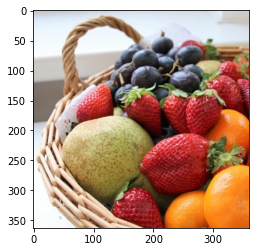

Image 2:


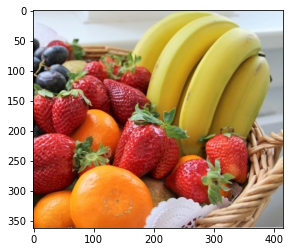

Images loaded
Features extracted from image 1
Feature Nr. 0 :(x1= 36 ;y1= 239 ).
Feature Nr. 1 :(x1= 36 ;y1= 249 ).
Feature Nr. 2 :(x1= 38 ;y1= 244 ).
Feature Nr. 3 :(x1= 38 ;y1= 253 ).
Feature Nr. 4 :(x1= 40 ;y1= 226 ).
Feature Nr. 5 :(x1= 40 ;y1= 227 ).
Feature Nr. 6 :(x1= 40 ;y1= 255 ).
Feature Nr. 7 :(x1= 40 ;y1= 256 ).
Feature Nr. 8 :(x1= 41 ;y1= 229 ).
Feature Nr. 9 :(x1= 41 ;y1= 255 ).
Feature Nr. 10 :(x1= 41 ;y1= 256 ).
Feature Nr. 11 :(x1= 42 ;y1= 256 ).
Feature Nr. 12 :(x1= 42 ;y1= 298 ).
Feature Nr. 13 :(x1= 43 ;y1= 262 ).
Feature Nr. 14 :(x1= 44 ;y1= 261 ).
Feature Nr. 15 :(x1= 44 ;y1= 262 ).
Feature Nr. 16 :(x1= 46 ;y1= 261 ).
Feature Nr. 17 :(x1= 46 ;y1= 282 ).
Feature Nr. 18 :(x1= 47 ;y1= 170 ).
Feature Nr. 19 :(x1= 47 ;y1= 283 ).
Feature Nr. 20 :(x1= 47 ;y1= 320 ).
Feature Nr. 21 :(x1= 48 ;y1= 223 ).
Feature Nr. 22 :(x1= 48 ;y1= 224 ).
Feature Nr. 23 :(x1= 48 ;y1= 225 ).
Feature Nr. 24 :(x1= 48 ;y1= 226 ).
Feature Nr. 25 :(x1= 48 ;y1= 284 ).
Feature Nr. 26 :(x1= 48 ;y1=

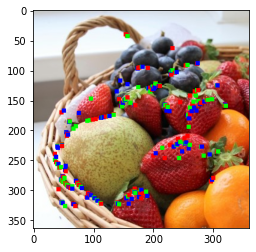

Features extracted from image 2
Feature Nr. 0 :(x2= 36 ;y2= 193 ).
Feature Nr. 1 :(x2= 36 ;y2= 229 ).
Feature Nr. 2 :(x2= 37 ;y2= 172 ).
Feature Nr. 3 :(x2= 38 ;y2= 161 ).
Feature Nr. 4 :(x2= 38 ;y2= 172 ).
Feature Nr. 5 :(x2= 40 ;y2= 167 ).
Feature Nr. 6 :(x2= 41 ;y2= 167 ).
Feature Nr. 7 :(x2= 44 ;y2= 151 ).
Feature Nr. 8 :(x2= 47 ;y2= 142 ).
Feature Nr. 9 :(x2= 48 ;y2= 133 ).
Feature Nr. 10 :(x2= 52 ;y2= 150 ).
Feature Nr. 11 :(x2= 55 ;y2= 155 ).
Feature Nr. 12 :(x2= 56 ;y2= 141 ).
Feature Nr. 13 :(x2= 56 ;y2= 226 ).
Feature Nr. 14 :(x2= 57 ;y2= 226 ).
Feature Nr. 15 :(x2= 57 ;y2= 227 ).
Feature Nr. 16 :(x2= 58 ;y2= 226 ).
Feature Nr. 17 :(x2= 58 ;y2= 227 ).
Feature Nr. 18 :(x2= 61 ;y2= 151 ).
Feature Nr. 19 :(x2= 61 ;y2= 152 ).
Feature Nr. 20 :(x2= 65 ;y2= 144 ).
Feature Nr. 21 :(x2= 65 ;y2= 145 ).
Feature Nr. 22 :(x2= 66 ;y2= 148 ).
Feature Nr. 23 :(x2= 66 ;y2= 149 ).
Feature Nr. 24 :(x2= 67 ;y2= 148 ).
Feature Nr. 25 :(x2= 67 ;y2= 149 ).
Feature Nr. 26 :(x2= 70 ;y2= 240 ).
Featur

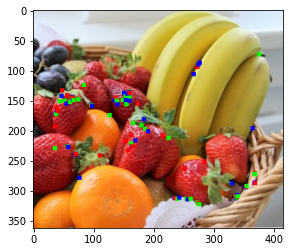

Features described
Features matched
Match Nr. 0 :(x1= 259 ;y1= 193 ).(x2= 36 ;y2= 193 ).
Match Nr. 1 :(x1= 259 ;y1= 194 ).(x2= 36 ;y2= 193 ).
Match Nr. 2 :(x1= 259 ;y1= 230 ).(x2= 36 ;y2= 229 ).
Match Nr. 3 :(x1= 260 ;y1= 173 ).(x2= 37 ;y2= 172 ).
Match Nr. 4 :(x1= 261 ;y1= 162 ).(x2= 38 ;y2= 161 ).
Match Nr. 5 :(x1= 261 ;y1= 173 ).(x2= 37 ;y2= 172 ).
Match Nr. 6 :(x1= 261 ;y1= 173 ).(x2= 38 ;y2= 172 ).
Match Nr. 7 :(x1= 267 ;y1= 152 ).(x2= 44 ;y2= 151 ).
Match Nr. 8 :(x1= 275 ;y1= 151 ).(x2= 52 ;y2= 150 ).
Match Nr. 9 :(x1= 278 ;y1= 156 ).(x2= 55 ;y2= 155 ).
Match Nr. 10 :(x1= 280 ;y1= 227 ).(x2= 56 ;y2= 226 ).
Match Nr. 11 :(x1= 280 ;y1= 227 ).(x2= 57 ;y2= 226 ).
Match Nr. 12 :(x1= 280 ;y1= 227 ).(x2= 58 ;y2= 226 ).
Match Nr. 13 :(x1= 281 ;y1= 227 ).(x2= 57 ;y2= 226 ).
Match Nr. 14 :(x1= 281 ;y1= 227 ).(x2= 58 ;y2= 226 ).
Match Nr. 15 :(x1= 281 ;y1= 227 ).(x2= 58 ;y2= 227 ).
Match Nr. 16 :(x1= 284 ;y1= 153 ).(x2= 61 ;y2= 152 ).
Match Nr. 17 :(x1= 285 ;y1= 152 ).(x2= 61 ;y2= 152 ).
Ma

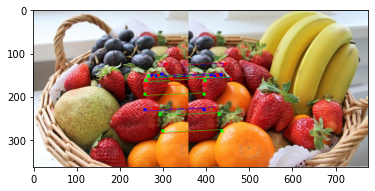

In [5]:
# Initialize the source images
image1=cv2.imread("fruit-basket_a.jpg")
image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
image2=cv2.imread("fruit-basket_b.jpg")
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
    
matchResult=detectAndMatchFeatures(image1,image2,output=True)

In [6]:
pos1 = matchResult[0]
pos2 = matchResult[1]

In [7]:
#find homography

image1_coordinates = []
image2_coordinates = []

for i in range(0, len(matchResult[2]), 1):
    image1_coordinates.append([pos1[0][matchResult[2][i]], pos1[1][matchResult[2][i]], 1])
    
for i in range(0, len(matchResult[3]), 1):
    image2_coordinates.append([pos2[0][matchResult[3][i]], pos2[1][matchResult[3][i]], 1])

# Create matrix A using the coordinates selected on image 1 and image 2
A = np.zeros((2*len(image1_coordinates), 9)) #ToDo

for i in range(0, len(image1_coordinates)):
    A[2*i][0] = image2_coordinates[i][0]*image1_coordinates[i][2] #ToDo # x*w'
    A[2*i][1] = image2_coordinates[i][1]*image1_coordinates[i][2] #ToDo # y*w'
    A[2*i][2] = image2_coordinates[i][2]*image1_coordinates[i][2] #ToDo # w*w'
    
    A[2*i][6] = -1*image2_coordinates[i][0]*image1_coordinates[i][0] # -x*x'
    A[2*i][7] = -1*image2_coordinates[i][1]*image1_coordinates[i][0] # -y*x'
    A[2*i][8] = -1*image2_coordinates[i][2]*image1_coordinates[i][0] # -w*x'
    
    A[2*i+1][3] = image2_coordinates[i][0]*image1_coordinates[i][2] #x*w'
    A[2*i+1][4] = image2_coordinates[i][1]*image1_coordinates[i][2] #y*w'
    A[2*i+1][5] = image2_coordinates[i][2]*image1_coordinates[i][2] #w*w'
    
    A[2*i+1][6] = -1*image2_coordinates[i][0]*image1_coordinates[i][1] #-x*y'
    A[2*i+1][7] = -1*image2_coordinates[i][1]*image1_coordinates[i][1] #-y*y'
    A[2*i+1][8] = -1*image2_coordinates[i][2]*image1_coordinates[i][1] #-w*y'
    
# Get svd
u,s,v_trans = np.linalg.svd(A) #ToDo
h = v_trans[8]

# Normalize homography and put into matrix form
# Put h into homography form and normalize each value by h
homography = np.array([ [ h[0]/h[8], h[1]/h[8], h[2]/h[8] ], [ h[3]/h[8], h[4]/h[8], h[5]/h[8] ], [ h[6]/h[8], h[7]/h[8], h[8]/h[8] ] ])

homography = np.around(homography, decimals=4)
print(homography)

[[ 8.039000e-01 -5.350000e-02  2.278145e+02]
 [-8.500000e-02  9.083000e-01  1.161190e+01]
 [-5.000000e-04 -2.000000e-04  1.000000e+00]]


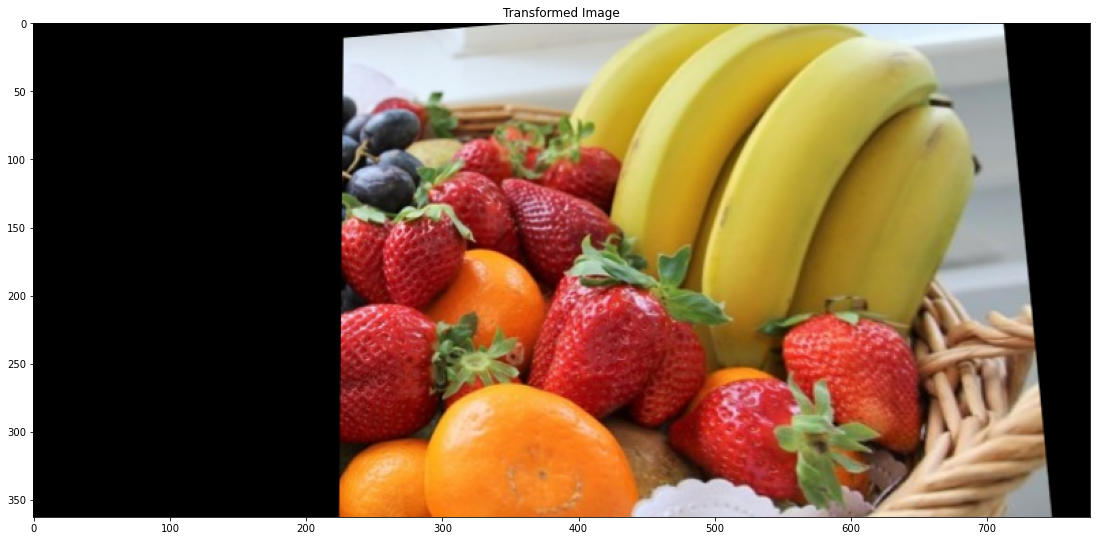

In [14]:
# Transform the second image with homography
# Use warpPerspective method from cv2 to apply homography on image2
resulting_image = cv2.warpPerspective(image2, homography, (image1.shape[1] + image2.shape[1], image1.shape[0]))

# Show the results
fig = plt.figure(figsize=(20, 20))
columns = 2
rows = 2

fig.add_subplot(2,2,(1,2))               
plt.title('Transformed Image')
plt.imshow(resulting_image)
plt.show()

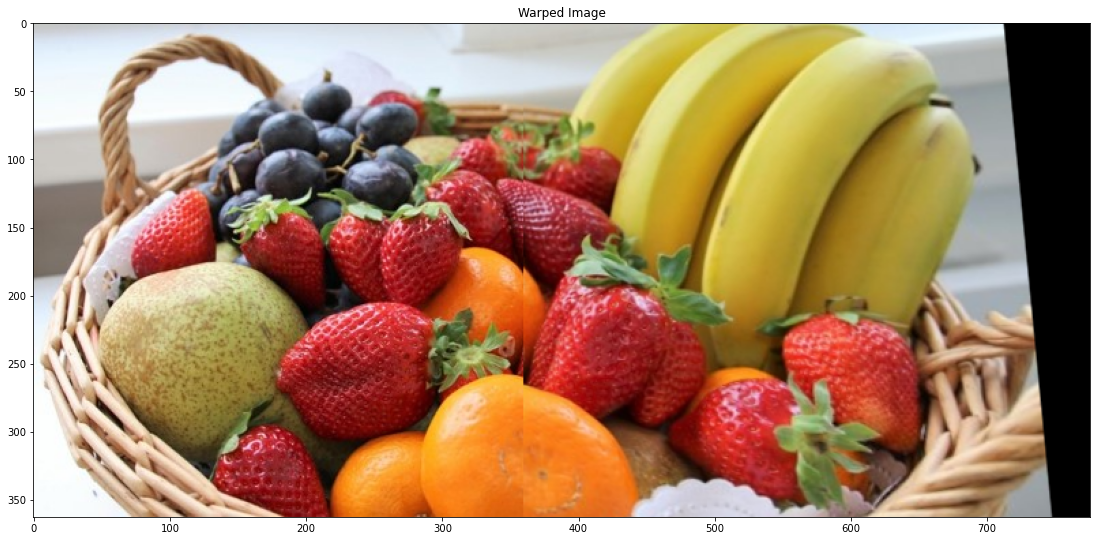

In [15]:
# Warp the transformed image with the first image by filling pixels from image1

# Fill in the pixels from image1 to fully warp the images
resulting_image[0:image1.shape[0], 0:image1.shape[1]] = #ToDo
resulting_image = cv2.cvtColor(resulting_image, cv2.COLOR_BGR2RGB)

# Show the results
fig = plt.figure(figsize=(20, 20))
columns = 2
rows = 2

fig.add_subplot(2,2,(1,2))               
plt.title('Warped Image')
plt.imshow(cv2.cvtColor(resulting_image, cv2.COLOR_BGR2RGB))
plt.show()